In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.datasets import cifar10
from collections import Counter
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

### Reproducibility

In [2]:
SEED = 22
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Set class number to train for

In [3]:
KEEP_CLASS_NUMBER = 7

### General functions

In [4]:
def get_class_summary(y):
    y_flat = y.flatten() 
    counter = Counter(y_flat)
    return counter

In [5]:
def plot_distribution(class_counts):
    labels, counts = zip(*sorted(class_counts.items()))
    label_names = [class_names[label] for label in labels]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_names, y=counts)
    plt.title('Distribution of classes')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [6]:
def show_image_grid(X, y, rows, cols, figsize):
    # Create a new figure
    plt.figure(figsize=figsize)
  
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i])
        plt.title(class_names[y[i][0]])
    
    plt.show()

#### CNN structure

In [7]:
def build_simple_cnn(input_shape=(32, 32, 3), num_classes=KEEP_CLASS_NUMBER):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # CNN Block 1
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # CNN Block 2
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # CNN Block 3
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    cnn_output = tf.keras.layers.Flatten(name='cnn_output')(x)

    # Dense layers
    dense_1 = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(cnn_output)
    dropout_1 = tf.keras.layers.Dropout(0.5)(dense_1)

    # Final layer (logits before softmax)
    logits = Dense(num_classes, name='logits')(dropout_1)
    outputs = tf.keras.layers.Softmax(name='softmax')(logits)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

#### Isolation forest

In [8]:
from sklearn.ensemble import IsolationForest

def fit_iso_forest(n_estimators, contamination, train_features, test_features):
    # Initialize the model
    iso_forest = IsolationForest(
        n_estimators=n_estimators,
        contamination=contamination,
        random_state=SEED
    )
    
    # Fit the model
    iso_forest.fit(train_features)
    
    # Predict anomalies (-1 = outlier, 1 = inlier)
    predictions = iso_forest.predict(test_features)
    
    # Get anomaly scores (the lower, the more anomalous)
    anomaly_scores = iso_forest.decision_function(test_features)

    return anomaly_scores, predictions

In [9]:
def show_anomaly_score_plot(anomaly_scores):
    plt.hist(anomaly_scores, bins=50)
    plt.title("Anomaly Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.show()

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def print_evaluation_report(y_true, y_pred, target_names=['Unknown (OOD)', 'Known'], labels=[-1, 1], save_path = None):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy*100:.2f}%")

    print(classification_report(y_true, y_pred, target_names=target_names))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved to {save_path}")
    plt.show()


In [11]:
def correct_predictions_with_unknown(class_preds, predictions, fallback_class):
    all_preds = np.argmax(class_preds, axis=-1)
    y_pred = np.zeros(predictions.shape[0], dtype=int)
    
    mask = predictions != -1
    y_pred[mask] = all_preds[mask]
    y_pred[~mask] = fallback_class
    
    return y_pred

# Load dataset from library

In [12]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [13]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (50000, 32, 32, 3)
Train Labels Shape:       (50000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


## CIFAR-10 classes

In [14]:
original_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_names = ['bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'automobile', 'airplane']

In [15]:
CLASS_NUMBER = 10

## Remap labels for easier handling

In [16]:
label_mapping = {original_class_names.index(name): class_names.index(name) for name in original_class_names}

In [17]:
y_train_mapped = np.vectorize(label_mapping.get)(y_train)
y_test_mapped = np.vectorize(label_mapping.get)(y_test)

# Exclude 3 classes from training
Excluded class: airplane, automobile, truck (last in list)

# Divide into trained and unknown classes

In [18]:
keep_classes = list(range(KEEP_CLASS_NUMBER))
other_classes = list(set(range(CLASS_NUMBER)) - set(range(KEEP_CLASS_NUMBER)))

# Masks
train_keep_mask = np.isin(y_train_mapped.flatten(), keep_classes)
test_keep_mask = np.isin(y_test_mapped.flatten(), keep_classes)

train_unknown_mask = np.isin(y_train_mapped.flatten(), other_classes)
test_unknown_mask = np.isin(y_test_mapped.flatten(), other_classes)

# Apply
X_train_filtered = X_train[train_keep_mask]
y_train_filtered = y_train_mapped[train_keep_mask]

X_test_filtered = X_test[test_keep_mask]
y_test_filtered = y_test_mapped[test_keep_mask]

X_train_unknown = X_train[train_unknown_mask]
y_train_unknown = y_train_mapped[train_unknown_mask]
X_test_unknown = X_test[test_unknown_mask]
y_test_unknown = y_test_mapped[test_unknown_mask]

In [19]:
print("Train labels and counts:", get_class_summary(y_train_filtered))
print("Test labels and counts:", get_class_summary(y_test_filtered))
print("Unknown train labels and counts:", get_class_summary(y_train_unknown))
print("Unknown test labels and counts:", get_class_summary(y_test_unknown))

Train labels and counts: Counter({4: 5000, 2: 5000, 0: 5000, 5: 5000, 6: 5000, 1: 5000, 3: 5000})
Test labels and counts: Counter({1: 1000, 6: 1000, 4: 1000, 3: 1000, 5: 1000, 2: 1000, 0: 1000})
Unknown train labels and counts: Counter({7: 5000, 8: 5000, 9: 5000})
Unknown test labels and counts: Counter({9: 1000, 8: 1000, 7: 1000})


# Preprocess images

## One-hot encoding of labels

In [20]:
enc = OneHotEncoder()
y_train_enc=enc.fit_transform(y_train_filtered).toarray().astype(int)
y_test_enc=enc.transform(y_test_filtered).toarray().astype(int)

## Flow generation

In [21]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [22]:
train_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=128,
    shuffle=True,
    seed=SEED,
    subset='training'
)

val_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=128,
    shuffle=True,
    seed=SEED,
    subset='validation'
)

test_flow = test_generator.flow(
    x=X_test_filtered,
    y=y_test_enc,
    batch_size=128,
    shuffle=False
)

# CNN for classification

In [23]:
my_model = build_simple_cnn()

### Compile model

In [24]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### Load saved weights

In [25]:
my_model.load_weights('models/my_model_weights_7_class_v2.keras')

# Evaluate model on known test set

In [26]:
loss, accuracy = my_model.evaluate(test_flow, verbose=1)
print(f"Test accuracy: {accuracy*100:.2f}%, test loss: {loss:.4f}")

55/55 [==============================] - 2s 17ms/step - loss: 0.6135 - accuracy: 0.8000
Test accuracy: 80.00%, test loss: 0.6135


# Extract intermediate models

In [27]:
# Model to get CNN output (flattened)
cnn_output_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('cnn_output').output)

# Model to get first Dense output
dense_output_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('dense_1').output)

# Model to get logits (before softmax)
logits_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('logits').output)

# Construct training set for isolation forest
Use the 7-class test set plus 10% contamination of randomly generated images

In [28]:
X_train_filtered.shape[0]

35000

## Reduce training set size to 20%, no need for all

In [29]:
n_samples = int(0.2 * len(X_train_filtered))
indices = np.random.choice(len(X_train_filtered), size=n_samples, replace=False)

X_subset = X_train_filtered[indices]
y_subset = y_train_filtered[indices]

## Generate artificial anomaly data

In [30]:
artificial_N = round(X_subset.shape[0] * 0.05)
uniform_images = np.random.uniform(low=0.0, high=1.0, size=(artificial_N, 32, 32, 3)).astype(np.float32)
normal_images = np.clip(np.random.normal(loc=0.5, scale=0.5, size=(artificial_N, 32, 32, 3)).astype(np.float32), 0.0, 1.0)
contamination_images = np.concatenate((uniform_images, normal_images), axis=0)
y_contamination = (KEEP_CLASS_NUMBER) * np.ones((artificial_N * 2, 1), dtype=np.int32)

In [31]:
contamination_images.shape

(700, 32, 32, 3)

## Create training set

In [32]:
X_train_iso =np.concatenate([X_subset, contamination_images], axis=0)
y_train_iso = np.concatenate([y_subset, y_contamination], axis=0)

In [33]:
X_train_iso.shape, y_train_iso.shape

((7700, 32, 32, 3), (7700, 1))

### Flow without validation split and data augmentation

In [34]:
iso_train_flow = test_generator.flow(X_train_iso, y_train_iso, batch_size=128, shuffle=False, seed=SEED)

# Construct mixed test set

In [35]:
enc_full = OneHotEncoder()
y_test_modified = np.where(y_test_mapped >= KEEP_CLASS_NUMBER, KEEP_CLASS_NUMBER, y_test_mapped)
y_full_test_enc = enc_full.fit_transform(y_test_modified).toarray().astype(int)
y_full_test_enc.shape

(10000, 8)

In [36]:
y_is_known = np.where(y_test_mapped >= KEEP_CLASS_NUMBER, -1, 1)

In [37]:
iso_test_flow = test_generator.flow(X_test, y_full_test_enc, batch_size=128, shuffle=False, seed=SEED)

# Evaluate original model on mixed test set

In [38]:
iso_test_flow = test_generator.flow(X_test, y_full_test_enc, batch_size=128, shuffle=False, seed=SEED)
class_preds = my_model.predict(iso_test_flow, verbose=1)

79/79 [==============================] - 2s 17ms/step


Accuracy: 56.00%
              precision    recall  f1-score   support

        bird       0.70      0.71      0.71      1000
         cat       0.76      0.54      0.63      1000
        deer       0.67      0.84      0.75      1000
         dog       0.84      0.65      0.73      1000
        frog       0.66      0.95      0.78      1000
       horse       0.69      0.92      0.79      1000
        ship       0.28      0.98      0.44      1000
     unknown       0.00      0.00      0.00      3000

    accuracy                           0.56     10000
   macro avg       0.58      0.70      0.60     10000
weighted avg       0.46      0.56      0.48     10000



C:\Users\encip\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\encip\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\encip\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

Confusion matrix saved to figures/10class_original.png


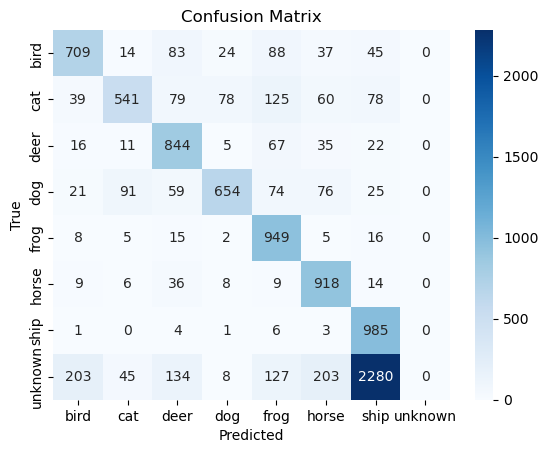

In [42]:
all_preds = np.argmax(class_preds, axis=-1)
target_names = ['bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'unknown']
print_evaluation_report(y_test_modified, all_preds, target_names = target_names, labels = range(len(target_names)), save_path="figures/10class_original.png")

# Extract features using different layers of the CNN classifier

## CNN as feature extractor
As the dimension out the output of the CNN is very high, we reduce it to 256 using PCA

### Prepare train features

In [43]:
from sklearn.decomposition import PCA
from tqdm import tqdm

pca = PCA(n_components=256)

# Process training flow - small enough for direct processing
train_features_cnn = cnn_output_model.predict(iso_train_flow, verbose=1)
print(train_features_cnn.shape)
train_features_cnn = pca.fit_transform(train_features_cnn)

61/61 [==============================] - 1s 16ms/step
(7700, 1024)


### Prepare test features

In [44]:
test_features_cnn = []
num_batches = len(iso_test_flow)
# Process test flow in batches, apply PCA by batch
for _ in tqdm(range(num_batches), desc="Processing test batches"):
    inputs, _ = next(iso_test_flow)
    batch_features = cnn_output_model.predict(inputs, verbose=0)
    reduced_features = pca.transform(batch_features)
    test_features_cnn.append(reduced_features)

test_features_cnn = np.concatenate(test_features_cnn, axis=0)

Processing test batches: 100%|█████████████████████████████████████████████████████████| 79/79 [00:07<00:00, 10.60it/s]


In [45]:
train_features_cnn.shape, test_features_cnn.shape

((7700, 256), (10000, 256))

### Fit isolation forest

In [46]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_cnn, 
    test_features = test_features_cnn
)
outlier_indices = np.where(predictions == -1)[0]

### Display unknown detection results

Accuracy: 66.31%
               precision    recall  f1-score   support

Unknown (OOD)       0.24      0.06      0.09      3000
        Known       0.70      0.92      0.79      7000

     accuracy                           0.66     10000
    macro avg       0.47      0.49      0.44     10000
 weighted avg       0.56      0.66      0.58     10000



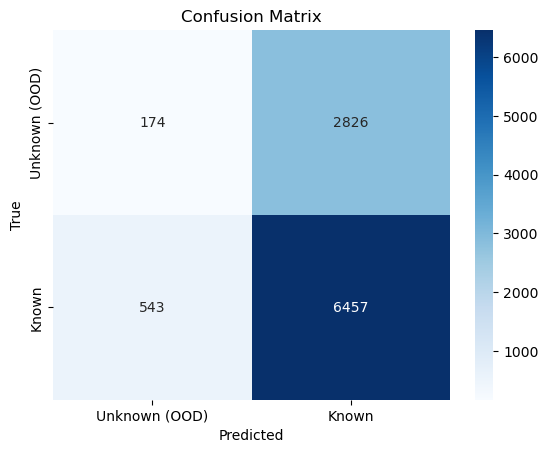

In [47]:
print_evaluation_report(y_is_known, predictions)

## Get modified accuracy

In [48]:
iso_test_flow = test_generator.flow(X_test, y_full_test_enc, batch_size=128, shuffle=False, seed=SEED)
class_preds = my_model.predict(iso_test_flow, verbose=1)

79/79 [==============================] - 1s 16ms/step


In [49]:
class_preds.shape, y_full_test_enc.shape, predictions.shape

((10000, 7), (10000, 8), (10000,))

### Construct adjusted predictions

In [50]:
y_pred = correct_predictions_with_unknown(class_preds, predictions, fallback_class=KEEP_CLASS_NUMBER)

### Evaluate accuracy

Accuracy: 52.84%
              precision    recall  f1-score   support

        bird       0.70      0.67      0.69      1000
         cat       0.75      0.51      0.61      1000
        deer       0.67      0.80      0.73      1000
         dog       0.82      0.53      0.65      1000
        frog       0.65      0.91      0.76      1000
       horse       0.66      0.76      0.70      1000
        ship       0.28      0.93      0.44      1000
     unknown       0.24      0.06      0.09      3000

    accuracy                           0.53     10000
   macro avg       0.60      0.65      0.58     10000
weighted avg       0.53      0.53      0.48     10000



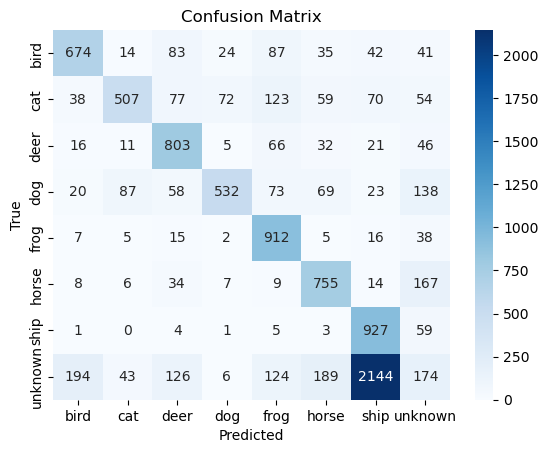

In [51]:
target_names = ['bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'unknown']
print_evaluation_report(y_test_modified, y_pred, target_names = target_names, labels = range(len(target_names)))

## Dense layer features

In [52]:
train_features_dense = dense_output_model.predict(iso_train_flow, verbose=1)
test_features_dense =  dense_output_model.predict(iso_test_flow, verbose=1)

79/79 [==============================] - 2s 19ms/step


In [53]:
train_features_dense.shape

(7700, 128)

In [54]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_dense, 
    test_features = test_features_dense
)

### Display results

Accuracy: 62.21%
               precision    recall  f1-score   support

Unknown (OOD)       0.04      0.01      0.02      3000
        Known       0.68      0.88      0.77      7000

     accuracy                           0.62     10000
    macro avg       0.36      0.45      0.39     10000
 weighted avg       0.49      0.62      0.54     10000



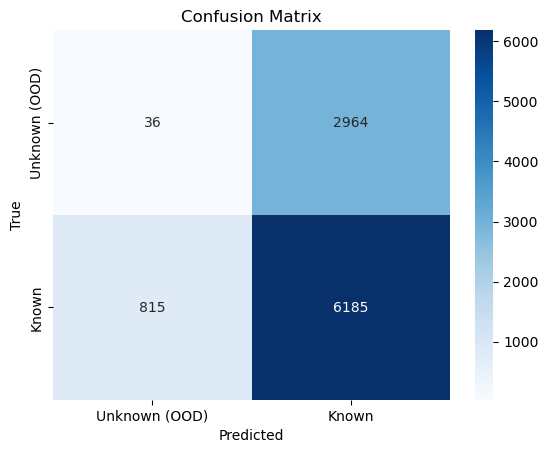

In [55]:
print_evaluation_report(y_is_known, predictions)

## Get modified accuracy

### Construct adjusted predictions

In [56]:
y_pred = correct_predictions_with_unknown(class_preds, predictions, fallback_class=KEEP_CLASS_NUMBER)

### Evaluate accuracy

Accuracy: 48.32%
              precision    recall  f1-score   support

        bird       0.69      0.66      0.68      1000
         cat       0.74      0.49      0.59      1000
        deer       0.66      0.80      0.72      1000
         dog       0.81      0.52      0.64      1000
        frog       0.62      0.81      0.70      1000
       horse       0.65      0.78      0.71      1000
        ship       0.23      0.74      0.36      1000
     unknown       0.04      0.01      0.02      3000

    accuracy                           0.48     10000
   macro avg       0.56      0.60      0.55     10000
weighted avg       0.45      0.48      0.44     10000



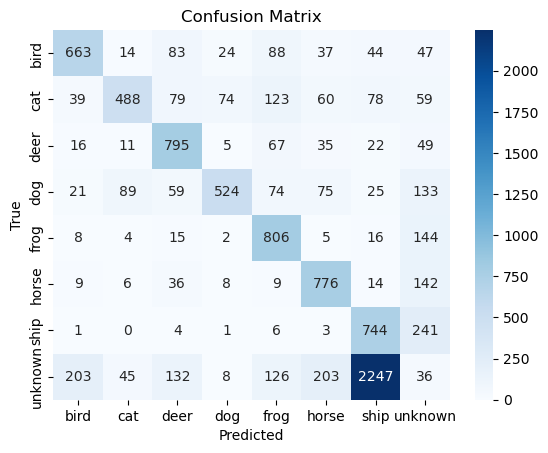

In [57]:
print_evaluation_report(y_test_modified, y_pred, target_names = target_names, labels = range(len(target_names)))

## Logits

In [58]:
train_features_logits = logits_model.predict(iso_train_flow, verbose=1)
test_features_logits =  logits_model.predict(iso_test_flow, verbose=1)

79/79 [==============================] - 1s 17ms/step


In [59]:
train_features_logits.shape

(7700, 7)

In [60]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_logits, 
    test_features = test_features_logits
)

### Display results

Accuracy: 63.24%
               precision    recall  f1-score   support

Unknown (OOD)       0.05      0.01      0.02      3000
        Known       0.68      0.90      0.77      7000

     accuracy                           0.63     10000
    macro avg       0.36      0.46      0.40     10000
 weighted avg       0.49      0.63      0.55     10000



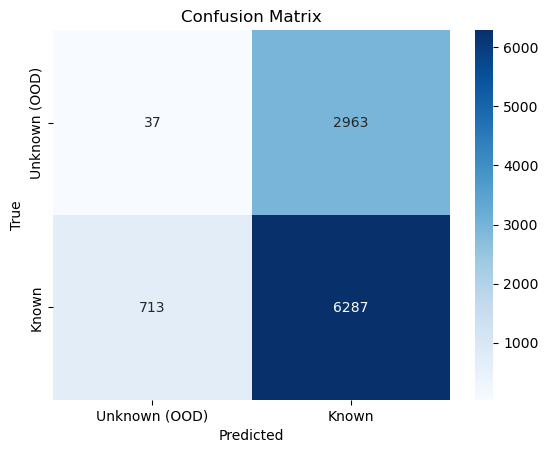

In [61]:
print_evaluation_report(y_is_known, predictions)

## Get modified accuracy

### Construct adjusted predictions

In [62]:
y_pred = correct_predictions_with_unknown(class_preds, predictions, fallback_class=KEEP_CLASS_NUMBER)

### Evaluate accuracy

Accuracy: 49.42%
              precision    recall  f1-score   support

        bird       0.70      0.70      0.70      1000
         cat       0.75      0.50      0.60      1000
        deer       0.66      0.78      0.71      1000
         dog       0.82      0.54      0.65      1000
        frog       0.64      0.86      0.73      1000
       horse       0.61      0.65      0.63      1000
        ship       0.26      0.88      0.41      1000
     unknown       0.05      0.01      0.02      3000

    accuracy                           0.49     10000
   macro avg       0.56      0.61      0.56     10000
weighted avg       0.46      0.49      0.45     10000



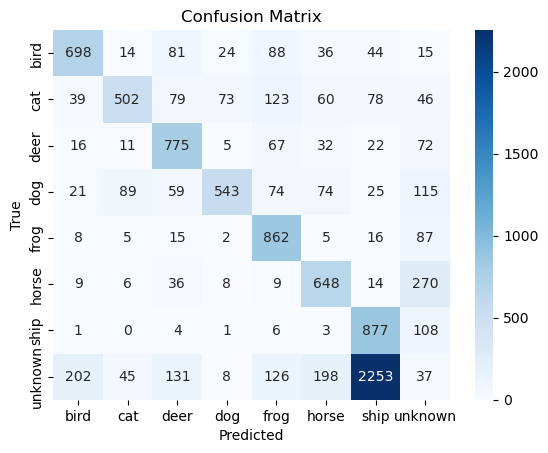

In [63]:
print_evaluation_report(y_test_modified, y_pred, target_names = target_names, labels = range(len(target_names)))

## Model output

In [64]:
train_features = my_model.predict(iso_train_flow, verbose=1)
test_features =  my_model.predict(iso_test_flow, verbose=1)

79/79 [==============================] - 1s 17ms/step


In [65]:
train_features.shape

(7700, 7)

In [66]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features, 
    test_features = test_features
)

### Display results

Accuracy: 70.16%
               precision    recall  f1-score   support

Unknown (OOD)       0.50      0.28      0.36      3000
        Known       0.74      0.88      0.81      7000

     accuracy                           0.70     10000
    macro avg       0.62      0.58      0.58     10000
 weighted avg       0.67      0.70      0.67     10000

Confusion matrix saved to figures/unknown_softmax.png


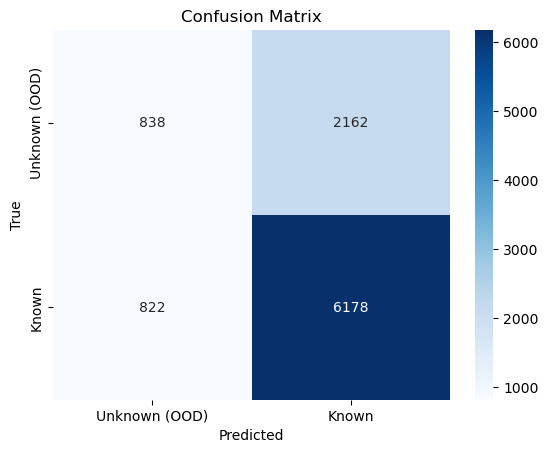

In [67]:
print_evaluation_report(y_is_known, predictions, save_path="figures/unknown_softmax.png")

## Get modified accuracy

### Construct adjusted predictions

In [68]:
y_pred = correct_predictions_with_unknown(class_preds, predictions, fallback_class=KEEP_CLASS_NUMBER)

### Evaluate accuracy

Accuracy: 60.28%
              precision    recall  f1-score   support

        bird       0.81      0.56      0.66      1000
         cat       0.82      0.43      0.56      1000
        deer       0.72      0.82      0.77      1000
         dog       0.85      0.60      0.70      1000
        frog       0.70      0.94      0.80      1000
       horse       0.77      0.89      0.83      1000
        ship       0.34      0.96      0.51      1000
     unknown       0.50      0.28      0.36      3000

    accuracy                           0.60     10000
   macro avg       0.69      0.68      0.65     10000
weighted avg       0.65      0.60      0.59     10000

Confusion matrix saved to figures/10class_softmax.png


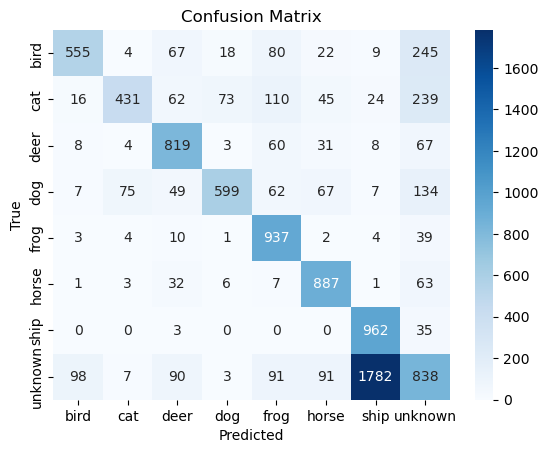

In [69]:
print_evaluation_report(y_test_modified, y_pred, target_names = target_names, labels = range(len(target_names)), save_path="figures/10class_softmax.png")

In [75]:
known_test_features =  my_model.predict(test_flow, verbose=1)

55/55 [==============================] - 1s 20ms/step


In [76]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features, 
    test_features = known_test_features
)

In [77]:
class_preds = np.argmax(class_preds, axis=-1)

In [79]:
y_pred_known = correct_predictions_with_unknown(known_test_features, predictions, fallback_class=KEEP_CLASS_NUMBER)

Accuracy: 74.14%
              precision    recall  f1-score   support

        bird       0.94      0.56      0.70      1000
         cat       0.83      0.43      0.57      1000
        deer       0.79      0.82      0.80      1000
         dog       0.86      0.60      0.70      1000
        frog       0.75      0.94      0.83      1000
       horse       0.84      0.89      0.86      1000
        ship       0.95      0.96      0.95      1000
     unknown       0.00      0.00      0.00         0

    accuracy                           0.74      7000
   macro avg       0.74      0.65      0.68      7000
weighted avg       0.85      0.74      0.77      7000



C:\Users\encip\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\encip\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\encip\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix saved to figures/7class_softmax.png


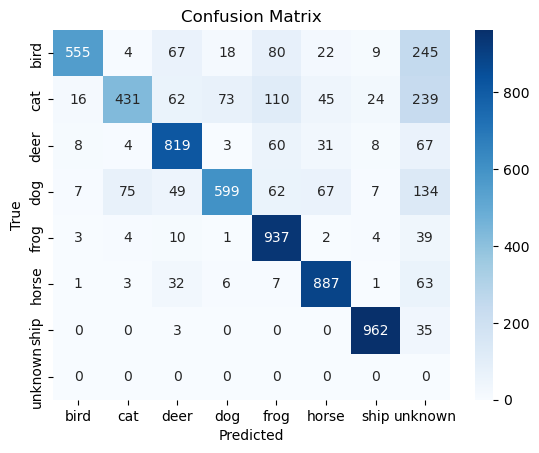

In [81]:
print_evaluation_report(y_test_filtered, y_pred_known, target_names = target_names, labels = range(len(target_names)), save_path="figures/7class_softmax.png")